# Draft on MCMC methods for bayesian regression 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

In [2]:
x = np.linspace(0,10,10000)
y_clean = 2*x 
y_noisy = y_clean + np.random.normal(0,1,(x.shape))

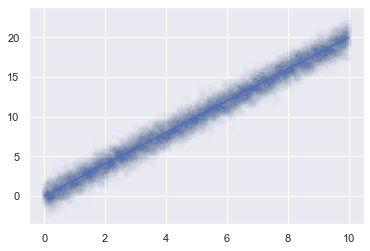

In [3]:
plt.plot(x,y_clean)
plt.scatter(x,y_noisy,alpha=.01)

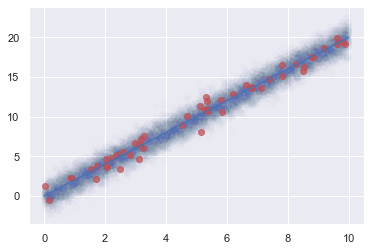

In [4]:
observed = np.random.randint(0,len(x)-1,50)
x_observed  = x[observed]
y_observed  = y_noisy[observed]

plt.plot(x,y_clean)
plt.scatter(x,y_noisy,alpha=.01)
plt.scatter(x_observed,y_observed,alpha=.7,c='r',label='observed values')

# the bayesian model 

* prior : N(0,1), uniform positive 
* Transition for MC : N((.1,.1),(.1,.1))
* likelyhood : N(a*X,sigma)

In [5]:
#The tranistion model defines how to move from sigma_current to sigma_new
# transition_model = lambda x: np.random.normal(x,[.1,1],(2,))

def transition_proba(x):
    '''
    '''
    return np.random.normal(x,[.1]*len(x),(len(x),))
def prior_mu(x):
    sigma= 1
    mu   = 1
    return 1.0 / (sigma * (2.0 * np.pi)**(1/2)) * np.exp(-1.0 * (x - mu)**2 / (2.0 * (sigma**2)))

def prior_sigma(x):
    '''
    We choose the prior to be exponential 
    '''
    if x>0:
        return 1
    else:
        return 0 
    return .5*np.exp(-.5*x)
    
def prior(w):
    '''
    priors on the the parameters 
    '''
    # prior on mu 
    
    # prior on sigma 
    p_mu = prior_mu(w[0])
    p_sigma = prior_sigma(w[1])
    return p_mu*p_sigma

#Computes the likelihood of the data given a sigma (new or current) according to equation (2)
def log_like_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data[1]-x[0]*data[0])**2) / (2*x[1]**2))

#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))


def metropolis_hastings(likelihood_fun,prior, transition_model, param_init,iterations,data,acceptance_rule):
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_proba(x)    
        x_lik = likelihood_fun(x,data)
        x_new_lik = likelihood_fun(x_new,data) 
        if (acceptance_rule(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)            
                
    return np.array(accepted), np.array(rejected)

In [7]:
accepted, rejected = metropolis_hastings(log_like_normal,prior,transition_proba,[1,0.1], 1000000,[x_observed,y_observed],acceptance)


In [8]:
mu = [x[0] for x in accepted]
sigma = [x[1] for x in accepted]

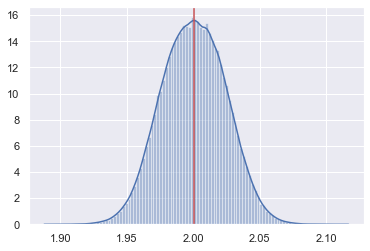

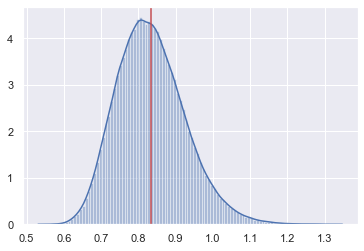

In [9]:
sns.distplot(mu[100:],bins=100)
plt.axvline(np.mean(mu[1000:]),c='r')
plt.figure()
sns.distplot(sigma[1000:],bins=100)
plt.axvline(np.mean(sigma[1000:]),c='r')


## Further example : Bayesian A/B testing with pyMC3

let's imagine that we change the price of an item in two comparable stores, analyze the impact using MCMC 

In [192]:
import pymc3 as pm

In [199]:
sales_store_A = 6
sales_store_B = 5

price_A = 7
price_B = 15
ab_testing_days = 30

In [200]:
# we simulate the sales of two similar stores as a poisson distribution 

a = pm.Poisson.dist(mu=sales_store_A)
b = pm.Poisson.dist(mu=sales_store_B)

store_a = a.random(size=ab_testing_days)
store_b = b.random(size=ab_testing_days)
with pm.Model() as model:

    p_a = pm.Uniform('prior_a',1,10)
    p_b = pm.Uniform('prior_b',1,10)
    
    delta = pm.Deterministic("delta_to",  (price_B*p_b-price_A*p_a))

    obs_a = pm.Poisson("obs_a",p_a, observed=store_a)
    obs_b = pm.Poisson("obs_b",p_b, observed=store_b)
    # To be explained in chapter 3.
    step = pm.NUTS()
    trace = pm.sample(50000, step=step,cores=4)
    burned_trace=trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prior_b, prior_a]
Sampling 4 chains, 0 divergences: 100%|███████████████████████████████████| 202000/202000 [01:08<00:00, 2958.75draws/s]


In [201]:
p_A_samples = burned_trace["prior_a"]
p_B_samples = burned_trace["prior_b"]
delta_samples = burned_trace["delta_to"]


Probability of having gains 1.000


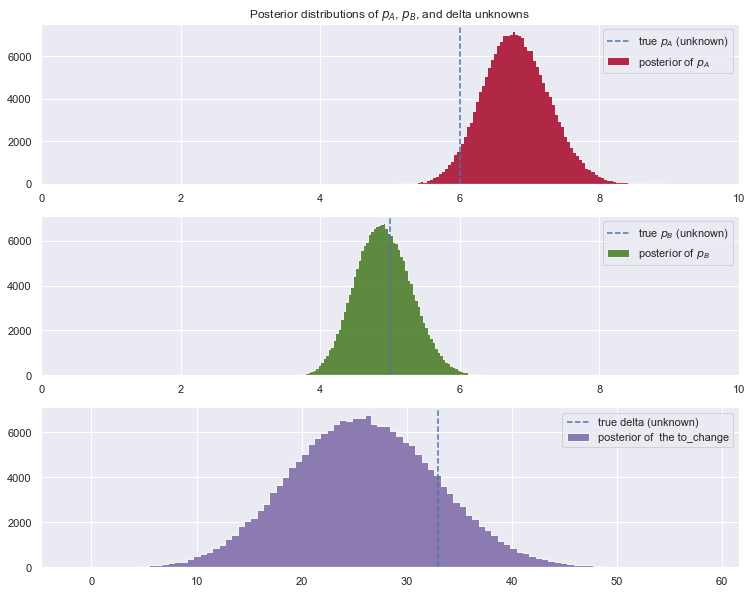

In [202]:
plt.figure(figsize=(12.5, 10))

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, 10)
plt.hist(p_A_samples, histtype='stepfilled', bins=100, alpha=0.85,
         label="posterior of $p_A$", color="#A60628")
plt.axvline(sales_store_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, 10)
plt.hist(p_B_samples, histtype='stepfilled', bins=100, alpha=0.85,
         label="posterior of $p_B$", color="#467821")
plt.axvline(sales_store_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
# plt.xlim(-1000, 1000)

plt.hist(delta_samples, histtype='stepfilled', bins=100, alpha=0.85,
         label="posterior of  the to_change", color="#7A68A6")
plt.axvline((price_B*sales_store_B-price_A*sales_store_A) , 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.legend(loc="upper right")

print(f'Probability of having gains {np.sum(delta_samples>0)/len(delta_samples):.3f}')

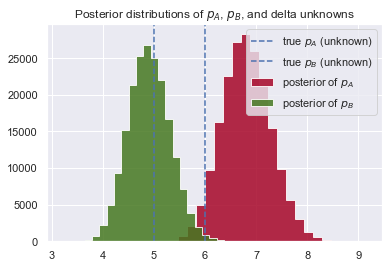

In [203]:
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628")
plt.axvline(sales_store_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821")
plt.axvline(sales_store_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

In [204]:
np.sum(delta_samples>0)/len(delta_samples)

0.9999591836734694